In [1]:
import os
import torch
import matplotlib.pyplot as plt
from utils.resnet_rand import resnet18, SparsifyFiltersLayer, SparsifyKernelGroups
from typing import Any, Type, Union
import numpy as np
import torch.nn as nn

In [20]:
ckpt = "model_best.pth_best.tar"
model_path_1=  "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_600547deae5b3d506d5c0befd9134c77/Checkpoints"
ckpt_path_1 = os.path.join(model_path_1, ckpt)
plot_path_1 = model_path_1.replace("Checkpoints", "Plots")
model_path_2 = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_2ec2f01d64d67544298a8ba4e5303489/Checkpoints"
ckpt = "model_best.pth.tar"
ckpt_path_2 = os.path.join(model_path_2, ckpt)
plot_path_2 = model_path_2.replace("Checkpoints", "Plots")

In [21]:
scale_factor=2
sparsefilter="SparsifyKernelGroups"
# Select sparseblock here
sparseblock : Type[Union[SparsifyFiltersLayer, SparsifyKernelGroups]]

if sparsefilter == 'SparsifyFiltersLayer':
    sparseblock = SparsifyFiltersLayer
elif sparsefilter == 'SparsifyKernelGroups':
    sparseblock = SparsifyKernelGroups


In [29]:
loc="cpu"
ckpt = torch.load(ckpt_path_1, map_location=loc)
model_1 = resnet18(sparsefilter=sparseblock,scale_factor=scale_factor)
model_1.fc = torch.nn.Linear(512, 10)
model_1.load_state_dict(ckpt['state_dict'])
model_1 = model_1.to(loc)

In [23]:
loc="cpu"
ckpt = torch.load(ckpt_path_2, map_location=loc)
model_2 = resnet18(sparsefilter=sparseblock,scale_factor=scale_factor)
model_2.fc = torch.nn.Linear(512, 10)
model_2.load_state_dict(ckpt['state_dict'])
model_2 = model_2.to(loc)

# Visualize filters

In [6]:
selected_kernel_indices = [0,1, 20,21, 40,41, 60,61, 80,81]
selected_kernels = model_2.layer1[0].conv1.weight[selected_kernel_indices]
selected_filter_indices = list(range(0, 64, 3))
group_1 = selected_kernels[0::2, selected_filter_indices]
group_2 = selected_kernels[1::2, selected_filter_indices]

In [7]:
selected_kernel_groups = torch.concatenate((group_1, group_2), dim=1)
filter_nums = selected_kernel_groups.shape[1] // 2

In [ ]:
base_config = f"kernel_visualization_scale-factor_{scale_factor}_"
selected_kernel_indices = [0,1, 20,21, 40,41, 60,61, 80,81]

# Iterate over kernels
for name, param in model_2.named_modules():
    if "conv" in name and "layer" in name:
        kernel_vectors = param.weight.flatten(1)
        selected_kernels = model_2.layer1[0].conv1.weight[selected_kernel_indices]
        selected_filter_indices = list(range(0, 64, 3))
        group_1 = selected_kernels[0::2, selected_filter_indices]
        group_2 = selected_kernels[1::2, selected_filter_indices]

        selected_kernel_groups = torch.concatenate((group_1, group_2), dim=1)
        filter_nums = selected_kernel_groups.shape[1] // 2

        for f in range(selected_kernel_groups.shape[0]):
            # Init figure
            fig, axes = plt.subplots(2, filter_nums, figsize=(100, 10))
            axes = axes.flatten()
            filter_group_idx = selected_kernel_indices[f*2]
            kernel_config = base_config +  f"_{name}_filter-group-{filter_group_idx}.jpg"
            image_path = os.path.join(plot_path_1, kernel_config)
            fig.suptitle(f"Kernel Group {filter_group_idx}", fontsize=60)
            for ch, ax in enumerate(axes):
                curr_filter = selected_kernel_groups[f][ch]
                # Normalize
                f_min, f_max = curr_filter.min(), curr_filter.max()
                curr_filter = (curr_filter - f_min) / (f_max - f_min)
                curr_filter = curr_filter.detach().numpy()
                ax.imshow(curr_filter)
                ax.axis('off')
                filter_num_idx = ch % filter_nums
                ax.set_title(selected_filter_indices[filter_num_idx], fontsize=35)
            plt.savefig(image_path, bbox_inches='tight')
            

# Get distribution between filter groups across layers

# Regularized Model

In [24]:
MSE = nn.MSELoss()
kernel_distances_1 = []
mean_weights = []
for name, param in model_1.named_modules():
    if "conv" in name and "layer" in name:
        kernel_vectors = param.weight.flatten(1)
        group_1 = kernel_vectors[0::2]
        group_2 = kernel_vectors[1::2]
        l2_dist = MSE(group_1, group_2)
        mean_weights.append(group_2.mean())
        kernel_distances_1.append(l2_dist.detach().cpu().item())

        

# Unregularized Model

In [25]:
MSE = nn.MSELoss()
kernel_distances_2 = []
for name, param in model_2.named_modules():
    if "conv" in name and "layer" in name:
        kernel_vectors = param.weight.flatten(1)
        #print(kernel_vectors.shape)
        group_1 = kernel_vectors[0::2]
        group_2 = kernel_vectors[1::2]
        l2_dist = MSE(group_1, group_2)
        kernel_distances_2.append(l2_dist.detach().cpu().item())

        

# Plots

In [26]:
kernel_distances_1 = [round(d, 6) for d in kernel_distances_1]
mean_weights = [round(d.item(), 6) for d in mean_weights]
kernel_distances_2 = [round(d, 6) for d in kernel_distances_2]

In [27]:
x_axis = np.arange(1,len(kernel_distances_1)+1)

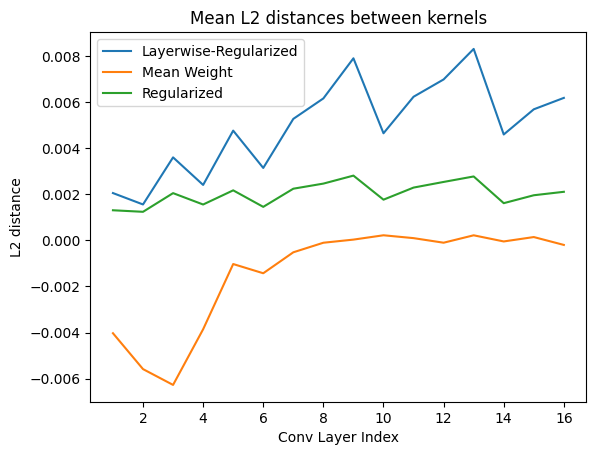

In [28]:
config = "Reg_Unreg_l2_comparison.jpg"
plt.title("Mean L2 distances between kernels")
plt.plot(x_axis, kernel_distances_1, label="Layerwise-Regularized")
plt.plot(x_axis, mean_weights, label="Mean Weight")
plt.plot(x_axis, kernel_distances_2, label="Regularized")
plt.legend()
plt.xlabel("Conv Layer Index")
plt.ylabel("L2 distance")

plot_path = os.path.join(plot_path_1, config)
#plt.savefig(plot_path, bbox_inches='tight')

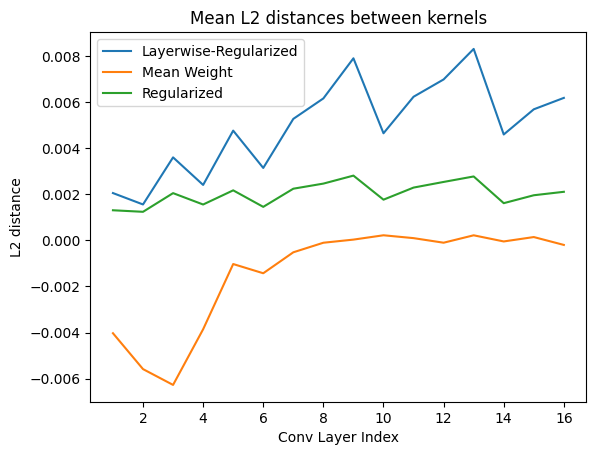

In [13]:
config = "Reg_Unreg_l2_comparison.jpg"
plt.title("Mean L2 distances between kernels")
plt.plot(x_axis, kernel_distances_1, label="Layerwise-Regularized")
plt.plot(x_axis, mean_weights, label="Mean Weight")
plt.plot(x_axis, kernel_distances_2, label="Regularized")
plt.legend()
plt.xlabel("Conv Layer Index")
plt.ylabel("L2 distance")

plot_path = os.path.join(plot_path_1, config)
#plt.savefig(plot_path, bbox_inches='tight')

In [14]:
plot_path

'/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_2ec2f01d64d67544298a8ba4e5303489/Plots/Reg_Unreg_l2_comparison.jpg'

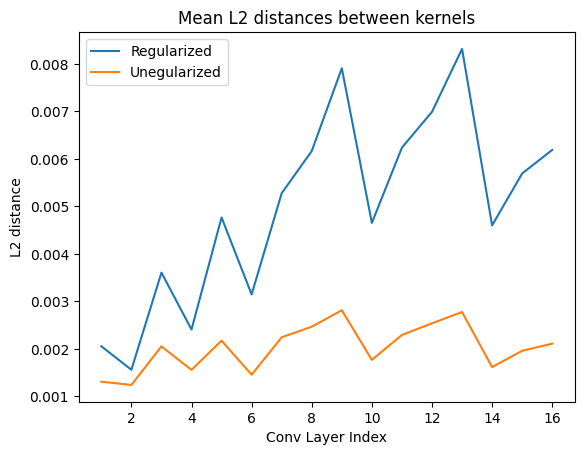

In [14]:
config = "Reg_Unreg_l2_comparison.jpg"
plt.title("Mean L2 distances between kernels")
plt.plot(x_axis, kernel_distances_1, label="Regularized")
plt.plot(x_axis, kernel_distances_2, label="Unegularized")
plt.legend()
plt.xlabel("Conv Layer Index")
plt.ylabel("L2 distance")

plot_path = os.path.join(plot_path_1, config)
#plt.savefig(plot_path, bbox_inches='tight')

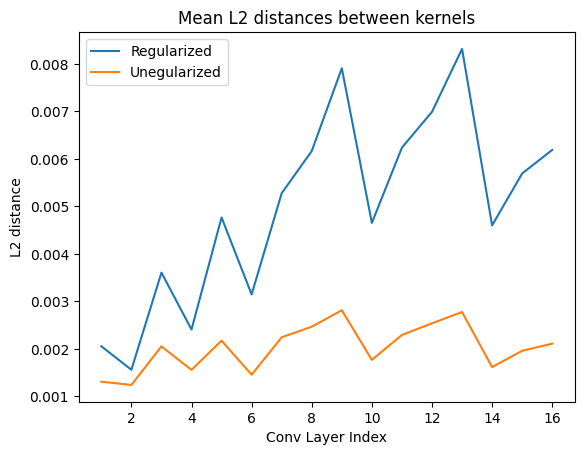

In [15]:
config = "Reg_Unreg_l2_comparison.jpg"
plt.title("Mean L2 distances between kernels")
plt.plot(x_axis, kernel_distances_1, label="Regularized")
plt.plot(x_axis, kernel_distances_2, label="Unegularized")
plt.legend()
plt.xlabel("Conv Layer Index")
plt.ylabel("L2 distance")

plot_path = os.path.join(plot_path_1, config)
#plt.savefig(plot_path, bbox_inches='tight')

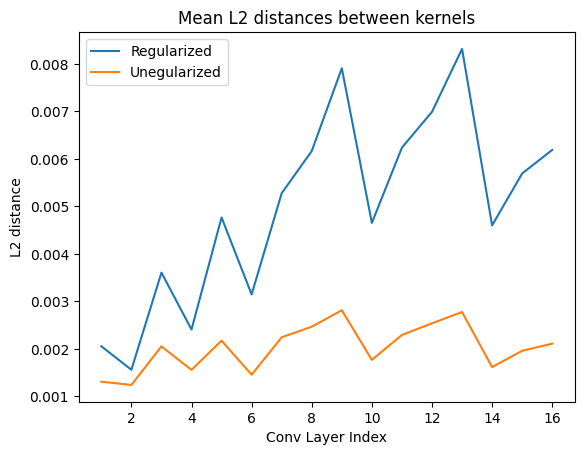

In [16]:
config = "Reg_Unreg_l2_comparison.jpg"
plt.title("Mean L2 distances between kernels")
plt.plot(x_axis, kernel_distances_1, label="Regularized")
plt.plot(x_axis, kernel_distances_2, label="Unegularized")
plt.legend()
plt.xlabel("Conv Layer Index")
plt.ylabel("L2 distance")

plot_path = os.path.join(plot_path_1, config)
plt.savefig(plot_path, bbox_inches='tight')